In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.figure as fig
import matplotlib.pyplot as plt
import math

from IPython.display import display, Markdown
from cycler import cycler
from adjustText import adjust_text

def display_md(content: str):
    display(Markdown(content))

In [2]:
epsilon_start = 0.9
epsilon_end = 0.025
epsilon_decay = 0.09

min_steps = 3
max_steps = 30
max_turns = 10000

def calculate_epsilon(turn: int, turns=max_turns, start=epsilon_start, end=epsilon_end, decay=epsilon_decay) -> float:
    return end + (start - end) * math.exp(-(turn / turns) * (decay * 100))

def clamp(v, minimum, maximum):
    return max(min(v, maximum), minimum)

In [3]:
def epsilon_plot(name: str, turns=max_turns, epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay, annotate_quantiles=True, annotate_break=True):
    data = np.array([calculate_epsilon(t, turns, epsilon_start, epsilon_end, epsilon_decay) for t in range(0, turns)])
    description = f"{turns} turns | {epsilon_start:.1%} to {epsilon_end:.1%} with {epsilon_decay:.3f} decay"
    plt.plot(data, label=f"{name}: {description}")
    plt.tick_params(labelsize="large")
    plt.ylabel("epsilon", fontsize="large")
    plt.xlabel("turn", fontsize="large")
    plt.legend(fontsize="large")
    
    annotations = []
    if annotate_quantiles:
        first_index = 100
        q2_index = int(turns * 0.5)
        q3_index = int(turns * 0.75)
        last_index = turns - 1
        annotations = [
            plt.annotate(f"{name} S: {data[first_index]:.1%}", (first_index, data[first_index]), fontsize="large", weight="bold", arrowprops={"arrowstyle": "->"}),
            plt.annotate(f"{name} Q2: {data[q2_index]:.1%}", (q2_index, data[q2_index]), fontsize="large", weight="bold", arrowprops={"arrowstyle": "->"}),
            plt.annotate(f"{name} Q3: {data[q3_index]:.1%}", (q3_index, data[q3_index]), fontsize="large", weight="bold", arrowprops={"arrowstyle": "->"}),
            plt.annotate(f"{name} E: {data[last_index]:.1%}", (last_index, data[last_index]), fontsize="large", weight="bold", arrowprops={"arrowstyle": "->"})
        ]
    if annotate_break:
        gradient = np.gradient(data)
        normalized_gradient = np.abs(gradient / np.linalg.norm(gradient, ord=np.inf))
        break_index = np.argmax(normalized_gradient <= 0.01)
        annotations.append(
            plt.annotate(f"{name} BR: T{break_index}={data[break_index]:.1%}", (break_index, data[break_index]), fontsize="large", weight="bold", arrowprops={"arrowstyle": "->"})
        )
    return annotations

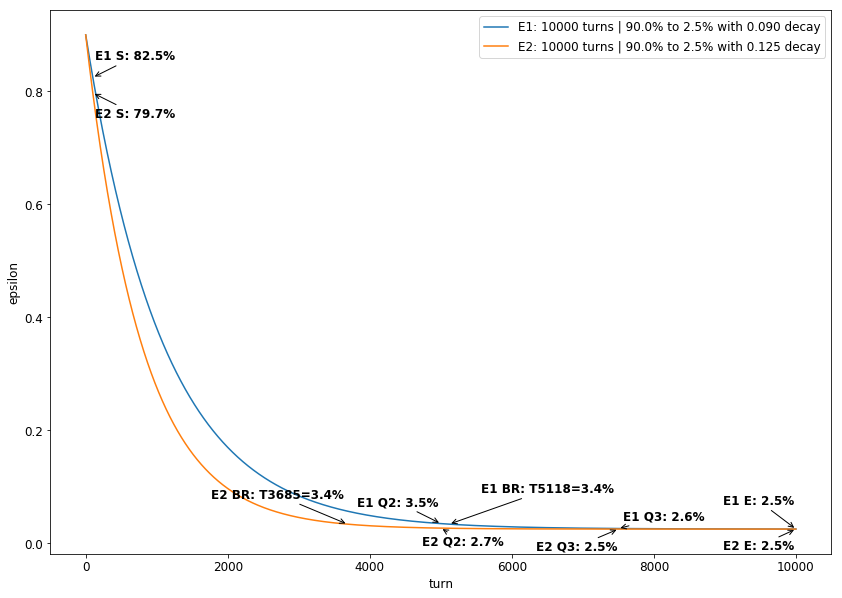

In [4]:
plt.figure(figsize=(14, 10))
plt.gca().set_prop_cycle(cycler(color=[cm.tab10(i) for i in range(10)]))
# for i in range(10):
#     decay = epsilon_decay - i * 0.005
#     epsilon_plot(name=f"E{i+1}", epsilon_decay=decay, annotate_quantiles=False, annotate_break=False)
annotations = [
    *epsilon_plot(name="E1"),
    *epsilon_plot(name="E2", epsilon_decay=0.125),
#     *epsilon_plot(name="E3", epsilon_decay=0.07, annotate_quantiles=False, annotate_break=False),
#     *epsilon_plot(name="E4", epsilon_decay=0.065, annotate_quantiles=False, annotate_break=False),
#     *epsilon_plot(name="E5", epsilon_decay=0.06),
]
adjust_text(annotations)
plt.show()

In [5]:
sample_size = 10000

def distribution(fn, bins=100, hist=True, label: str = None, shade=False):
    data = np.array([fn() for _ in range(sample_size)])
    plot = sns.distplot(data, bins=bins, hist=hist, label=label, kde_kws={"shade": shade})
    plot.set_xlim(data.min(), data.max())
    return plot

def plot_distribution(fn, bins=100):
    distribution(fn, bins)
    plt.show()
    
def plot_steps_distributions(fn, n=10, start_turn=0, end_turn=max_turns):
    plt.figure(figsize=(20, 12))
    sns.set_palette(sns.cubehelix_palette(n + 1, start=0.5, rot=-0.75, gamma=1.3, reverse=True))
    
    for turn in range(start_turn, end_turn + 1, (end_turn - start_turn) // n):
        distribution(lambda: random_steps(turn), hist=False, label=f"Turn {turn}")

    plt.legend(fontsize="large", ncol=2)
    plt.show()

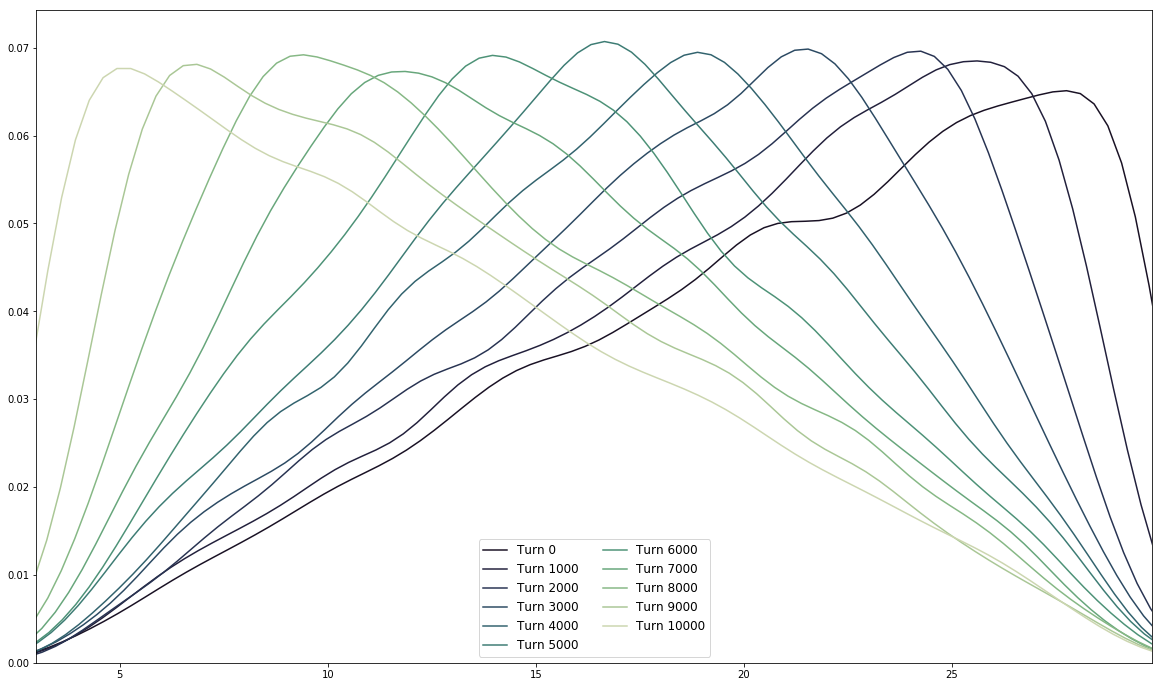

In [6]:
def random_steps(turn):
    mode = max_steps - (max_steps - min_steps) * (turn / max_turns)
    return random.triangular(min_steps, max_steps, mode=clamp(mode, min_steps, max_steps))

plot_steps_distributions(fn=random_steps, n=10)